# Multi-group Agreement (COMPAS)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the COMPAS
dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from compas_utils import months_since, preprocess_compas

# COMPAS Dataset
Parole records from Florida, USA, where the task is to predict whether an individual will recidivate within two years. Sensitive attributes are race and gender.
While every labeled dataset contains human biases inherent in collecting and categorizing the data, the COMPAS dataset in particular has been the subject of valid critiques, and is mostly included for comparisons to prior work. We note that the COMPAS dataset reflects the patterns of policing and social processes in a particular community (South Florida) at a specific time, and as others have noted [69], each stage of the COMPAS dataset’s creation introduces opportunities for bias [60, 4] and that measurement biases and errors with COMPAS have been widely documented [3].

COMPAS has $n = 7,215$ instances total, with $d = 10$ features.

In [2]:
compas_data = pd.read_csv("./datasets/compas/compas.csv", header=0, na_values='?')
compas_df = preprocess_compas(compas_data)
compas_df = compas_df.dropna()
print("COMPAS Shape: {}".format(compas_df.shape))

X, y = compas_df.drop("is_recid", axis=1), compas_df["is_recid"]
cat_idx = ['c_charge_degree', 'sex', 'race', 'screening_year_is_2013']
num_idx = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age']
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variale so we have two classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples recidivate (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples NOT recidivate (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

COMPAS Shape: (7214, 10)
% examples recidivate (y=1): 48.11477682284447
% examples NOT recidivate (y=0): 51.88522317715553


In [3]:
def compas_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 1) & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == 1) & (df['sex'] == sex_val))

group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["White", "NotWhite"]
sex_gps = [1, 0]

# Traditional disjoint groups
for race in race_gps_coarse:
    for sex in sex_gps:
        indices = compas_gp_indices(X, race, sex)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['race'] == 1)
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['race'] != 1)
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['sex'] == 1)
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['sex'] == 0)
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [4]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (7214, 14)


In [5]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			5771	1443
1 (W,M)			2428	616
2 (W,F)			522	130
3 (nW,M)			2212	563
4 (nW,F)			609	134
5 (W)			2950	746
6 (nW)			2821	697
7 (M)			4640	1179
8 (F)			1131	264


In [6]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.48995148995148996
P(Y=1 | group 1) = 0.5909090909090909
P(Y=1 | group 2) = 0.4461538461538462
P(Y=1 | group 3) = 0.42451154529307283
P(Y=1 | group 4) = 0.34328358208955223
P(Y=1 | group 5) = 0.5656836461126006
P(Y=1 | group 6) = 0.40889526542324245
P(Y=1 | group 7) = 0.5114503816793893
P(Y=1 | group 8) = 0.3939393939393939


## Utilities for Training/Evaluation

In [7]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [8]:
# Construct pairs of groups for "agreement" comparison
erm_group_pairs = list()
group_pairs = list()
group_pairs_cond = list()

# append G0 (ALL) paired with all other groups
for i in range(1, num_groups):
    erm_group_pairs.append((0, i))

# append pairs intersecting at G1 (W,M)
group_pairs.append((1,5))
group_pairs_cond.append(1)
group_pairs.append((5,7))
group_pairs_cond.append(1)
group_pairs.append((1,7))
group_pairs_cond.append(1)

# append pairs intersecting at G2 (W,F)
group_pairs.append((2,5))
group_pairs_cond.append(2)
group_pairs.append((5,8))
group_pairs_cond.append(2)
group_pairs.append((2,8))
group_pairs_cond.append(2)

# append pairs intersecting at G3 (nW,M)
group_pairs.append((3,6))
group_pairs_cond.append(3)
group_pairs.append((6,7))
group_pairs_cond.append(3)
group_pairs.append((3,7))
group_pairs_cond.append(3)

# append pairs intersecting at G4 (nW,F)
group_pairs.append((4,6))
group_pairs_cond.append(4)
group_pairs.append((6,8))
group_pairs_cond.append(4)
group_pairs.append((4,8))
group_pairs_cond.append(4)

# Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [10]:
# Train LogisticRegression models, one per group
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Get test errors for each group
lr_test_err = {}
for g in range(num_groups):
    lr_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, lr_test_err[g], std_err(lr_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

lr_erm_test_err = {}
for g in range(num_groups):
    lr_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.30561330561330563 (+/-0.017150178978937294; n=1443)
group 1 (W,M): 0.3003246753246753 (+/-0.02611971469657606; n=616)
group 2 (W,F): 0.3230769230769231 (+/-0.05800506938748756; n=130)
group 3 (nW,M): 0.3019538188277087 (+/-0.02736359421167892; n=563)
group 4 (nW,F): 0.2462686567164179 (+/-0.05263510057433427; n=134)
group 5 (W): 0.31233243967828417 (+/-0.023996251204253295; n=746)
group 6 (nW): 0.28694404591104733 (+/-0.024230312923147472; n=697)
group 7 (M): 0.30788804071246817 (+/-0.019012651254262512; n=1179)
group 8 (F): 0.2765151515151515 (+/-0.038930252559886476; n=264)
PREPEND group 0 (ALL): 0.30145530145530147 (+/-0.01708403276683732; n=1443)
PREPEND group 1 (W,M): 0.3003246753246753 (+/-0.02611971469657606; n=616)
PREPEND group 2 (W,F): 0.3230769230769231 (+/-0.05800506938748756; n=130)
PREPEND group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
PREPEND group 4 (nW,F): 0.2462686567164179 (+/-0.05263510057433427; n=134)
PREPEND group 5 (W): 0.30

In [11]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
lr_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    lr_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))


(W,M, W) agreement on G1 (W,M):	0.9772727272727273
(W, M) agreement on G1 (W,M):	0.9561688311688312
(W,M, M) agreement on G1 (W,M):	0.9496753246753247
(W,F, W) agreement on G2 (W,F):	0.9230769230769231
(W, F) agreement on G2 (W,F):	0.8923076923076924
(W,F, F) agreement on G2 (W,F):	0.9230769230769231
(nW,M, nW) agreement on G3 (nW,M):	0.9857904085257548
(nW, M) agreement on G3 (nW,M):	0.955595026642984
(nW,M, M) agreement on G3 (nW,M):	0.9662522202486679
(nW,F, nW) agreement on G4 (nW,F):	0.9477611940298507
(nW, F) agreement on G4 (nW,F):	0.9477611940298507
(nW,F, F) agreement on G4 (nW,F):	0.9701492537313433

(ALL, W,M) agreement:	0.9043659043659044
(ALL, W,F) agreement:	0.841995841995842
(ALL, nW,M) agreement:	0.9424809424809425
(ALL, nW,F) agreement:	0.8842688842688843
(ALL, W) agreement:	0.9410949410949411
(ALL, nW) agreement:	0.954954954954955
(ALL, M) agreement:	0.9653499653499653
(ALL, F) agreement:	0.8891198891198892


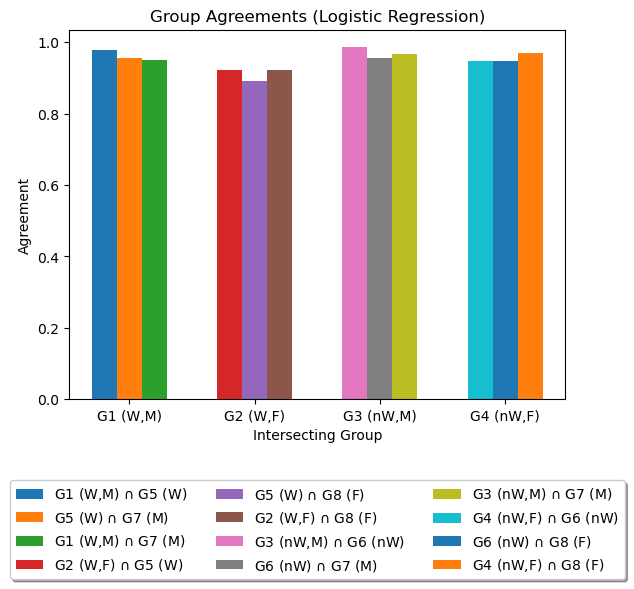

In [12]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, lr_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, lr_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, lr_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, lr_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, lr_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, lr_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, lr_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, lr_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, lr_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, lr_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, lr_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, lr_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Decision Trees

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

dt_test_err = {}
for g in range(num_groups):
    dt_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, dt_test_err[g], std_err(dt_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

dt_erm_test_err = {}
for g in range(num_groups):
    dt_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.3049203049203049 (+/-0.017139269429391337; n=1443)
group 1 (W,M): 0.30844155844155846 (+/-0.026316342477415815; n=616)
group 2 (W,F): 0.36153846153846153 (+/-0.05959199770321049; n=130)
group 3 (nW,M): 0.31616341030195383 (+/-0.02771358896745721; n=563)
group 4 (nW,F): 0.27611940298507465 (+/-0.05461909871538712; n=134)
group 5 (W): 0.33646112600536193 (+/-0.024465056148844793; n=746)
group 6 (nW): 0.2855093256814921 (+/-0.024193964566902607; n=697)
group 7 (M): 0.3104325699745547 (+/-0.019055928107901656; n=1179)
group 8 (F): 0.3143939393939394 (+/-0.04040986886909458; n=264)
group 0 (ALL): 0.3049203049203049 (+/-0.017139269429391337; n=1443)
group 1 (W,M): 0.30844155844155846 (+/-0.026316342477415815; n=616)
group 2 (W,F): 0.36153846153846153 (+/-0.05959199770321049; n=130)
group 3 (nW,M): 0.31616341030195383 (+/-0.02771358896745721; n=563)
group 4 (nW,F): 0.27611940298507465 (+/-0.05461909871538712; n=134)
group 5 (W): 0.33646112600536193 (+/-0.024465056148844793; n

In [15]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
dt_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    dt_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,M, W) agreement on G1 (W,M):	0.8847402597402597
(W, M) agreement on G1 (W,M):	0.875
(W,M, M) agreement on G1 (W,M):	0.922077922077922
(W,F, W) agreement on G2 (W,F):	0.8692307692307693
(W, F) agreement on G2 (W,F):	0.8384615384615385
(W,F, F) agreement on G2 (W,F):	0.8461538461538461
(nW,M, nW) agreement on G3 (nW,M):	0.8738898756660746
(nW, M) agreement on G3 (nW,M):	0.8809946714031972
(nW,M, M) agreement on G3 (nW,M):	0.8543516873889876
(nW,F, nW) agreement on G4 (nW,F):	0.8582089552238806
(nW, F) agreement on G4 (nW,F):	0.8805970149253731
(nW,F, F) agreement on G4 (nW,F):	0.8582089552238806

(ALL, W,M) agreement:	0.853083853083853
(ALL, W,F) agreement:	0.8281358281358281
(ALL, nW,M) agreement:	0.8655578655578655
(ALL, nW,F) agreement:	0.7574497574497574
(ALL, W) agreement:	0.8717948717948718
(ALL, nW) agreement:	0.8953568953568953
(ALL, M) agreement:	0.8974358974358975
(ALL, F) agreement:	0.8267498267498268


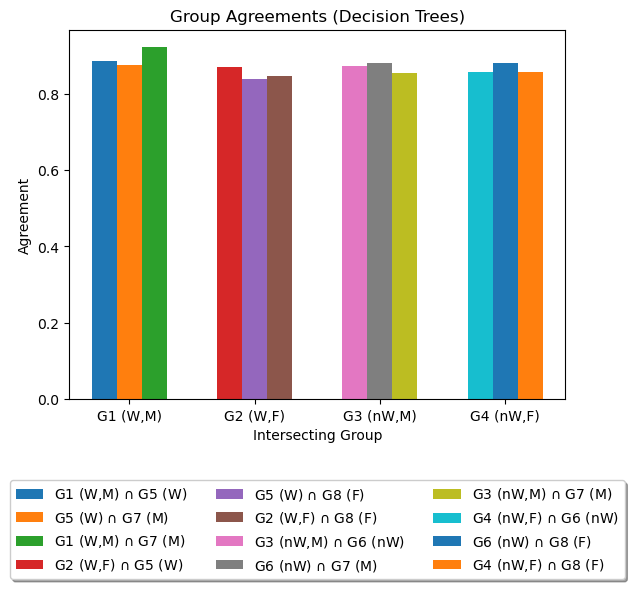

In [16]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, dt_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, dt_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, dt_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, dt_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, dt_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, dt_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, dt_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, dt_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, dt_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, dt_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, dt_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, dt_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Random Forests

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err = {}
for g in range(num_groups):
    rf_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, rf_test_err[g], std_err(rf_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

rf_erm_test_err = {}
for g in range(num_groups):
    rf_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.3042273042273042 (+/-0.01712831407006342; n=1443)
group 1 (W,M): 0.31655844155844154 (+/-0.026503442231502902; n=616)
group 2 (W,F): 0.35384615384615387 (+/-0.05930871686541635; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.32439678284182305 (+/-0.0242398377105771; n=746)
group 6 (nW): 0.28263988522238165 (+/-0.024120368914420633; n=697)
group 7 (M): 0.3104325699745547 (+/-0.019055928107901656; n=1179)
group 8 (F): 0.26515151515151514 (+/-0.038420144373355454; n=264)
group 0 (ALL): 0.3042273042273042 (+/-0.01712831407006342; n=1443)
group 1 (W,M): 0.31655844155844154 (+/-0.026503442231502902; n=616)
group 2 (W,F): 0.35384615384615387 (+/-0.05930871686541635; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.32439678284182305 (+/-0.0242398377105771; n=74

In [19]:
# Get group-conditional agreements
rf_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    rf_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,M, W) agreement on G1 (W,M):	0.9772727272727273
(W, M) agreement on G1 (W,M):	0.9821428571428571
(W,M, M) agreement on G1 (W,M):	0.9594155844155844
(W,F, W) agreement on G2 (W,F):	0.9461538461538461
(W, F) agreement on G2 (W,F):	0.9461538461538461
(W,F, F) agreement on G2 (W,F):	0.9076923076923077
(nW,M, nW) agreement on G3 (nW,M):	0.9467140319715808
(nW, M) agreement on G3 (nW,M):	0.9271758436944938
(nW,M, M) agreement on G3 (nW,M):	0.9449378330373002
(nW,F, nW) agreement on G4 (nW,F):	0.9328358208955224
(nW, F) agreement on G4 (nW,F):	0.9552238805970149
(nW,F, F) agreement on G4 (nW,F):	0.9776119402985075

(ALL, W,M) agreement:	0.9002079002079002
(ALL, W,F) agreement:	0.7484407484407485
(ALL, nW,M) agreement:	0.9022869022869023
(ALL, nW,F) agreement:	0.8572418572418572
(ALL, W) agreement:	0.9341649341649342
(ALL, nW) agreement:	0.9182259182259183
(ALL, M) agreement:	0.9473319473319474
(ALL, F) agreement:	0.8565488565488566


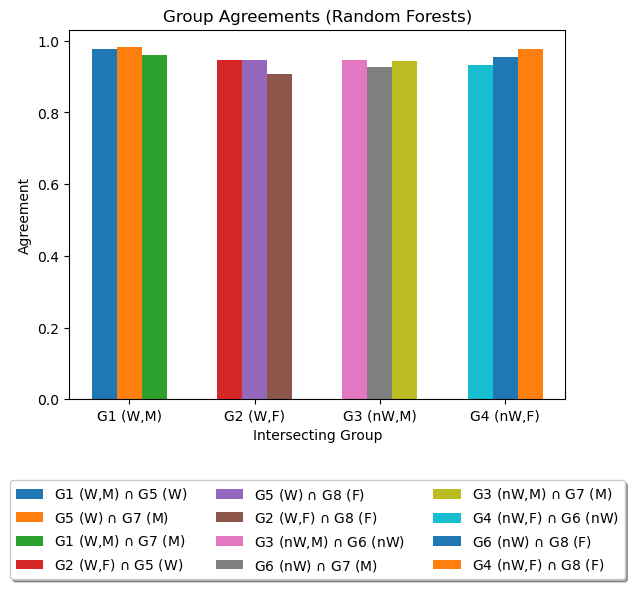

In [20]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, rf_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, rf_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, rf_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, rf_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, rf_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, rf_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, rf_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, rf_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, rf_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, rf_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, rf_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, rf_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Random Forests)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Gradient-Boosted Trees

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

gb_test_err = {}
for g in range(num_groups):
    gb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, gb_test_err[g], std_err(gb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

gb_erm_test_err = {}
for g in range(num_groups):
    gb_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.30214830214830213 (+/-0.017095172250837197; n=1443)
group 1 (W,M): 0.3116883116883117 (+/-0.026392314163407593; n=616)
group 2 (W,F): 0.36153846153846153 (+/-0.05959199770321049; n=130)
group 3 (nW,M): 0.3019538188277087 (+/-0.02736359421167892; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.3109919571045576 (+/-0.023968028286628383; n=746)
group 6 (nW): 0.28263988522238165 (+/-0.024120368914420633; n=697)
group 7 (M): 0.3061916878710772 (+/-0.0189834237834141; n=1179)
group 8 (F): 0.2840909090909091 (+/-0.03925279998339531; n=264)
group 0 (ALL): 0.30214830214830213 (+/-0.017095172250837197; n=1443)
group 1 (W,M): 0.3116883116883117 (+/-0.026392314163407593; n=616)
group 2 (W,F): 0.36153846153846153 (+/-0.05959199770321049; n=130)
group 3 (nW,M): 0.3019538188277087 (+/-0.02736359421167892; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.3109919571045576 (+/-0.023968028286628383; n=746)

In [23]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
gb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    gb_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,M, W) agreement on G1 (W,M):	0.9691558441558441
(W, M) agreement on G1 (W,M):	0.935064935064935
(W,M, M) agreement on G1 (W,M):	0.939935064935065
(W,F, W) agreement on G2 (W,F):	0.9230769230769231
(W, F) agreement on G2 (W,F):	0.8692307692307693
(W,F, F) agreement on G2 (W,F):	0.9
(nW,M, nW) agreement on G3 (nW,M):	0.9644760213143873
(nW, M) agreement on G3 (nW,M):	0.9218472468916519
(nW,M, M) agreement on G3 (nW,M):	0.9360568383658969
(nW,F, nW) agreement on G4 (nW,F):	0.9253731343283582
(nW, F) agreement on G4 (nW,F):	0.9253731343283582
(nW,F, F) agreement on G4 (nW,F):	0.9552238805970149

(ALL, W,M) agreement:	0.9064449064449065
(ALL, W,F) agreement:	0.8433818433818434
(ALL, nW,M) agreement:	0.9376299376299376
(ALL, nW,F) agreement:	0.8579348579348579
(ALL, W) agreement:	0.9251559251559252
(ALL, nW) agreement:	0.932085932085932
(ALL, M) agreement:	0.9348579348579349
(ALL, F) agreement:	0.8662508662508662


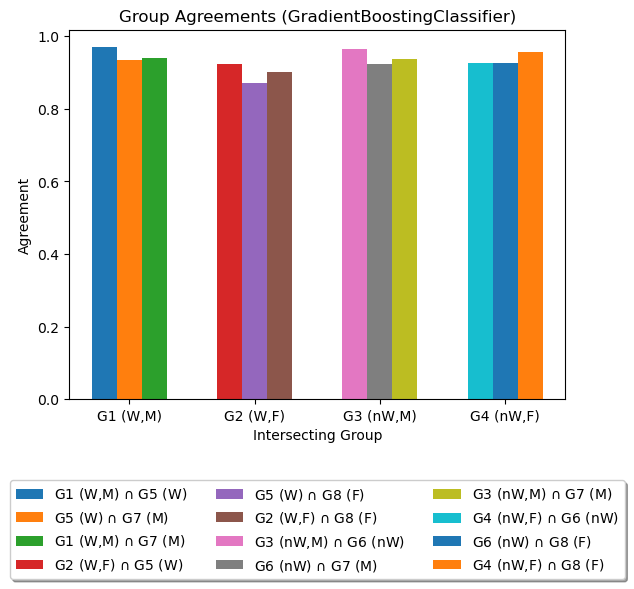

In [24]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, gb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, gb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, gb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, gb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, gb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, gb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, gb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, gb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, gb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, gb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, gb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, gb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (GradientBoostingClassifier)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# XGBoost

In [25]:
from xgboost import XGBClassifier

In [26]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

xgb_test_err = {}
for g in range(num_groups):
    xgb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, xgb_test_err[g], std_err(xgb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

xgb_erm_test_err = {}
for g in range(num_groups):
    xgb_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.306999306999307 (+/-0.01717186099756068; n=1443)
group 1 (W,M): 0.31006493506493504 (+/-0.02635451802786166; n=616)
group 2 (W,F): 0.34615384615384615 (+/-0.05900865137962601; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.21641791044776118 (+/-0.05030966769874355; n=134)
group 5 (W): 0.3109919571045576 (+/-0.023968028286628383; n=746)
group 6 (nW): 0.28407460545193686 (+/-0.024157317018574438; n=697)
group 7 (M): 0.30279898218829515 (+/-0.01892405959375801; n=1179)
group 8 (F): 0.29924242424242425 (+/-0.039857358905334477; n=264)
group 0 (ALL): 0.306999306999307 (+/-0.01717186099756068; n=1443)
group 1 (W,M): 0.31006493506493504 (+/-0.02635451802786166; n=616)
group 2 (W,F): 0.34615384615384615 (+/-0.05900865137962601; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.21641791044776118 (+/-0.05030966769874355; n=134)
group 5 (W): 0.3109919571045576 (+/-0.023968028286628383; n=746)

In [27]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
xgb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    xgb_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,M, W) agreement on G1 (W,M):	0.9724025974025974
(W, M) agreement on G1 (W,M):	0.9301948051948052
(W,M, M) agreement on G1 (W,M):	0.9285714285714286
(W,F, W) agreement on G2 (W,F):	0.9153846153846154
(W, F) agreement on G2 (W,F):	0.8846153846153846
(W,F, F) agreement on G2 (W,F):	0.8923076923076924
(nW,M, nW) agreement on G3 (nW,M):	0.9253996447602132
(nW, M) agreement on G3 (nW,M):	0.9342806394316163
(nW,M, M) agreement on G3 (nW,M):	0.8916518650088809
(nW,F, nW) agreement on G4 (nW,F):	0.9552238805970149
(nW, F) agreement on G4 (nW,F):	0.917910447761194
(nW,F, F) agreement on G4 (nW,F):	0.917910447761194

(ALL, W,M) agreement:	0.9154539154539154
(ALL, W,F) agreement:	0.8267498267498268
(ALL, nW,M) agreement:	0.8787248787248787
(ALL, nW,F) agreement:	0.8454608454608454
(ALL, W) agreement:	0.93000693000693
(ALL, nW) agreement:	0.9175329175329175
(ALL, M) agreement:	0.9452529452529452
(ALL, F) agreement:	0.8794178794178794


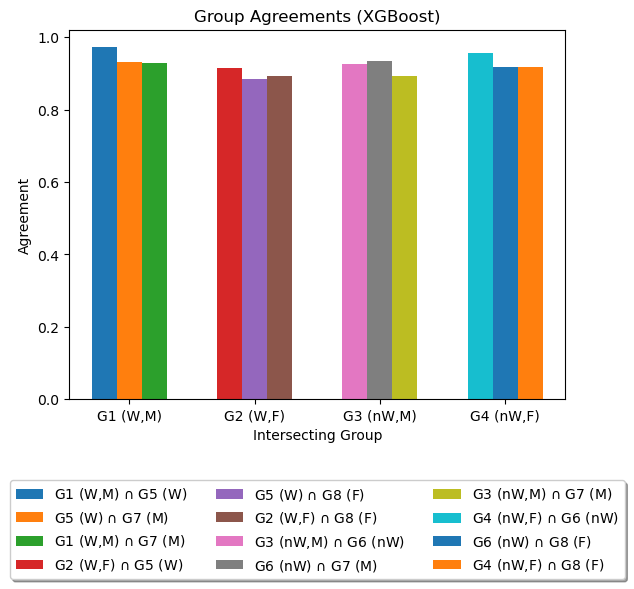

In [28]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, xgb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, xgb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, xgb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, xgb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, xgb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, xgb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, xgb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, xgb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, xgb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, xgb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, xgb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, xgb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        rf_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err = {}
for g in range(num_groups):
    rf_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, rf_test_err[g], std_err(rf_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

rf_erm_test_err = {}
for g in range(num_groups):
    rf_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.3042273042273042 (+/-0.01712831407006342; n=1443)
group 1 (W,M): 0.31655844155844154 (+/-0.026503442231502902; n=616)
group 2 (W,F): 0.35384615384615387 (+/-0.05930871686541635; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.32439678284182305 (+/-0.0242398377105771; n=746)
group 6 (nW): 0.28263988522238165 (+/-0.024120368914420633; n=697)
group 7 (M): 0.3104325699745547 (+/-0.019055928107901656; n=1179)
group 8 (F): 0.26515151515151514 (+/-0.038420144373355454; n=264)
group 0 (ALL): 0.3042273042273042 (+/-0.01712831407006342; n=1443)
group 1 (W,M): 0.31655844155844154 (+/-0.026503442231502902; n=616)
group 2 (W,F): 0.35384615384615387 (+/-0.05930871686541635; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.32439678284182305 (+/-0.0242398377105771; n=74

In [31]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
rf_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    rf_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(W,M, W) agreement on G1 (W,M):	0.9772727272727273
(W, M) agreement on G1 (W,M):	0.9821428571428571
(W,M, M) agreement on G1 (W,M):	0.9594155844155844
(W,F, W) agreement on G2 (W,F):	0.9461538461538461
(W, F) agreement on G2 (W,F):	0.9461538461538461
(W,F, F) agreement on G2 (W,F):	0.9076923076923077
(nW,M, nW) agreement on G3 (nW,M):	0.9467140319715808
(nW, M) agreement on G3 (nW,M):	0.9271758436944938
(nW,M, M) agreement on G3 (nW,M):	0.9449378330373002
(nW,F, nW) agreement on G4 (nW,F):	0.9328358208955224
(nW, F) agreement on G4 (nW,F):	0.9552238805970149
(nW,F, F) agreement on G4 (nW,F):	0.9776119402985075

(ALL, W,M) agreement:	0.9002079002079002
(ALL, W,F) agreement:	0.7484407484407485
(ALL, nW,M) agreement:	0.9022869022869023
(ALL, nW,F) agreement:	0.8572418572418572
(ALL, W) agreement:	0.9341649341649342
(ALL, nW) agreement:	0.9182259182259183
(ALL, M) agreement:	0.9473319473319474
(ALL, F) agreement:	0.8565488565488566


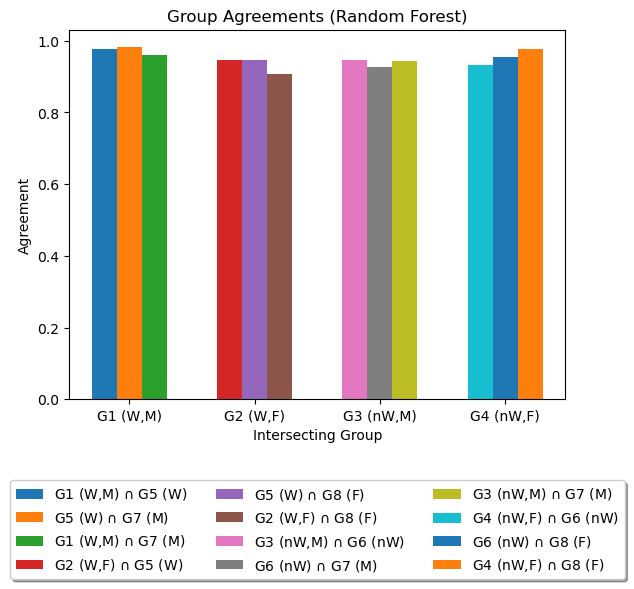

In [32]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, rf_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, rf_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, rf_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, rf_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, rf_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, rf_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, rf_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, rf_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, rf_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, rf_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, rf_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, rf_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (Random Forest)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# AdaBoost

In [33]:
from sklearn.ensemble import AdaBoostClassifier

In [34]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

ada_test_err = {}
for g in range(num_groups):
    ada_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, ada_test_err[g], std_err(ada_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

ada_erm_test_err = {}
for g in range(num_groups):
    ada_erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])

group 0 (ALL): 0.30214830214830213 (+/-0.017095172250837197; n=1443)
group 1 (W,M): 0.30194805194805197 (+/-0.026159812657746695; n=616)
group 2 (W,F): 0.3769230769230769 (+/-0.060109140608616406; n=130)
group 3 (nW,M): 0.32149200710479575 (+/-0.027837060571975547; n=563)
group 4 (nW,F): 0.26865671641791045 (+/-0.05415294608121959; n=134)
group 5 (W): 0.3096514745308311 (+/-0.023939570865446836; n=746)
group 6 (nW): 0.28263988522238165 (+/-0.024120368914420633; n=697)
group 7 (M): 0.3087362171331637 (+/-0.019027151947119535; n=1179)
group 8 (F): 0.29924242424242425 (+/-0.039857358905334477; n=264)
group 0 (ALL): 0.30214830214830213 (+/-0.017095172250837197; n=1443)
group 1 (W,M): 0.30194805194805197 (+/-0.026159812657746695; n=616)
group 2 (W,F): 0.3769230769230769 (+/-0.060109140608616406; n=130)
group 3 (nW,M): 0.32149200710479575 (+/-0.027837060571975547; n=563)
group 4 (nW,F): 0.26865671641791045 (+/-0.05415294608121959; n=134)
group 5 (W): 0.3096514745308311 (+/-0.0239395708654468

In [35]:
'''
# Get "agreement" for each pair of intersecting groups
lr_group_pairs_agreements = []
for g1, g2 in group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_group_pairs_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))
'''
# Get group-conditional agreements
ada_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    ada_group_pairs_agreements.append(agreement)

# Get "agreement" between ERM and each group
print()
for g1, g2 in erm_group_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))


(W,M, W) agreement on G1 (W,M):	0.9675324675324676
(W, M) agreement on G1 (W,M):	0.9090909090909091
(W,M, M) agreement on G1 (W,M):	0.9318181818181818
(W,F, W) agreement on G2 (W,F):	0.8769230769230769
(W, F) agreement on G2 (W,F):	0.8769230769230769
(W,F, F) agreement on G2 (W,F):	0.8769230769230769
(nW,M, nW) agreement on G3 (nW,M):	0.9058614564831261
(nW, M) agreement on G3 (nW,M):	0.911190053285968
(nW,M, M) agreement on G3 (nW,M):	0.8774422735346359
(nW,F, nW) agreement on G4 (nW,F):	0.9029850746268657
(nW, F) agreement on G4 (nW,F):	0.9328358208955224
(nW,F, F) agreement on G4 (nW,F):	0.8955223880597015

(ALL, W,M) agreement:	0.9223839223839224
(ALL, W,F) agreement:	0.7927927927927928
(ALL, nW,M) agreement:	0.9022869022869023
(ALL, nW,F) agreement:	0.8045738045738046
(ALL, W) agreement:	0.9355509355509356
(ALL, nW) agreement:	0.9265419265419266
(ALL, M) agreement:	0.9452529452529452
(ALL, F) agreement:	0.8537768537768538


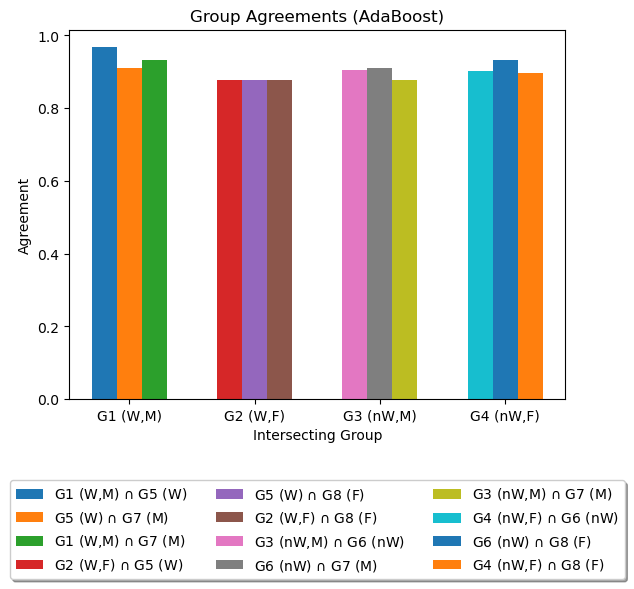

In [36]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

#rects1 = plt.bar(index - bar_width, group_pairs_agreements[0::3], bar_width)
rect11 = ax.bar(0 - bar_width, ada_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax.bar(0, ada_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax.bar(0 + bar_width, ada_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax.bar(1 - bar_width, ada_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax.bar(1, ada_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax.bar(1 + bar_width, ada_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax.bar(2 - bar_width, ada_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax.bar(2, ada_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax.bar(2 + bar_width, ada_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax.bar(3 - bar_width, ada_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax.bar(3, ada_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax.bar(3 + bar_width, ada_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()

# All Together

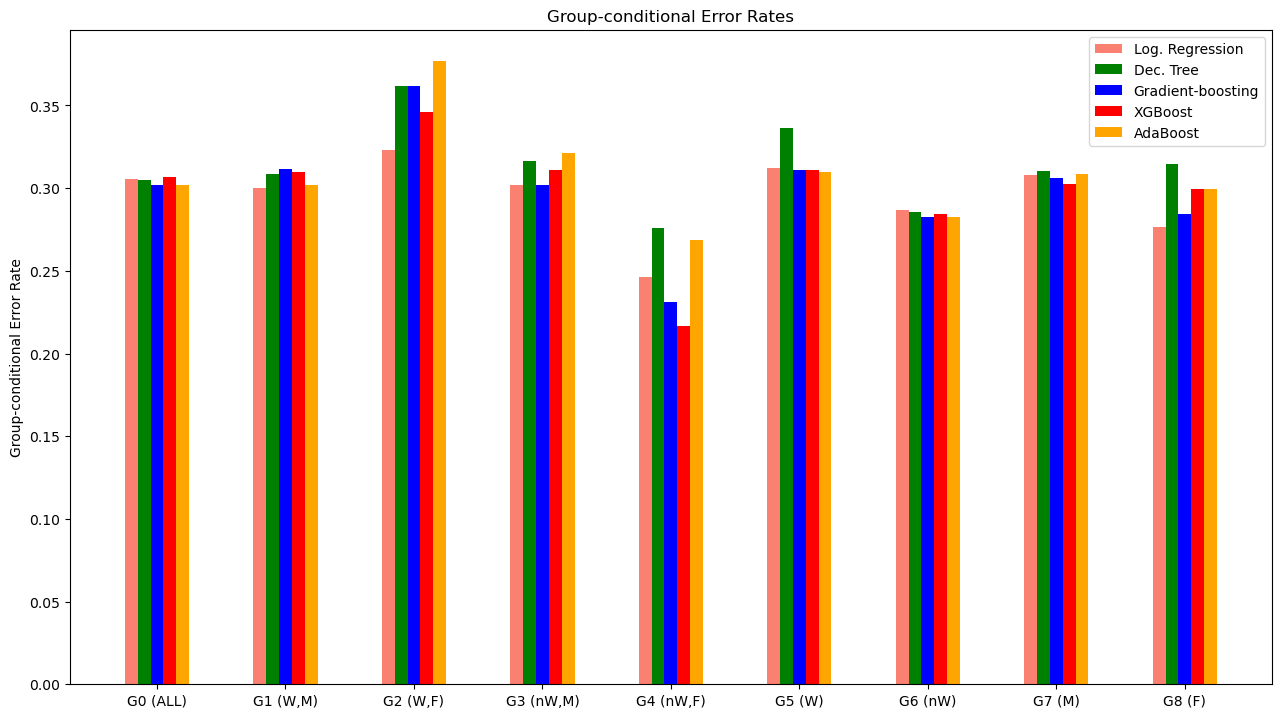

In [37]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2 * bar_width, lr_test_err[g], bar_width, label="Log. Regression", color="salmon")
        ax.bar(g - 1 * bar_width, dt_test_err[g], bar_width, label="Dec. Tree", color="green")
        ax.bar(g, gb_test_err[g], bar_width, label="Gradient-boosting", color="blue")
        ax.bar(g + 1 * bar_width, xgb_test_err[g], bar_width, label="XGBoost", color="red")
        ax.bar(g + 2 * bar_width, ada_test_err[g], bar_width, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2 * bar_width, lr_test_err[g], bar_width, color="salmon")
        ax.bar(g - 1 * bar_width, dt_test_err[g], bar_width, color="green")
        ax.bar(g, gb_test_err[g], bar_width, color="blue")
        ax.bar(g + 1 * bar_width, xgb_test_err[g], bar_width, color="red")
        ax.bar(g + 2 * bar_width, ada_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

In [38]:
from sklearn.metrics import accuracy_score

g1_lr = logreg_models[1]
g5_lr = logreg_models[5]
g7_lr = logreg_models[7]

g5_yhats = g5_lr.predict(col_transf.transform(X_test[group_test[1]]))
print(accuracy_score(y_test[group_test[1]], g5_yhats))
g7_yhats = g7_lr.predict(col_transf.transform(X_test[group_test[1]]))
print(accuracy_score(y_test[group_test[1]], g7_yhats))

0.6931818181818182
0.698051948051948


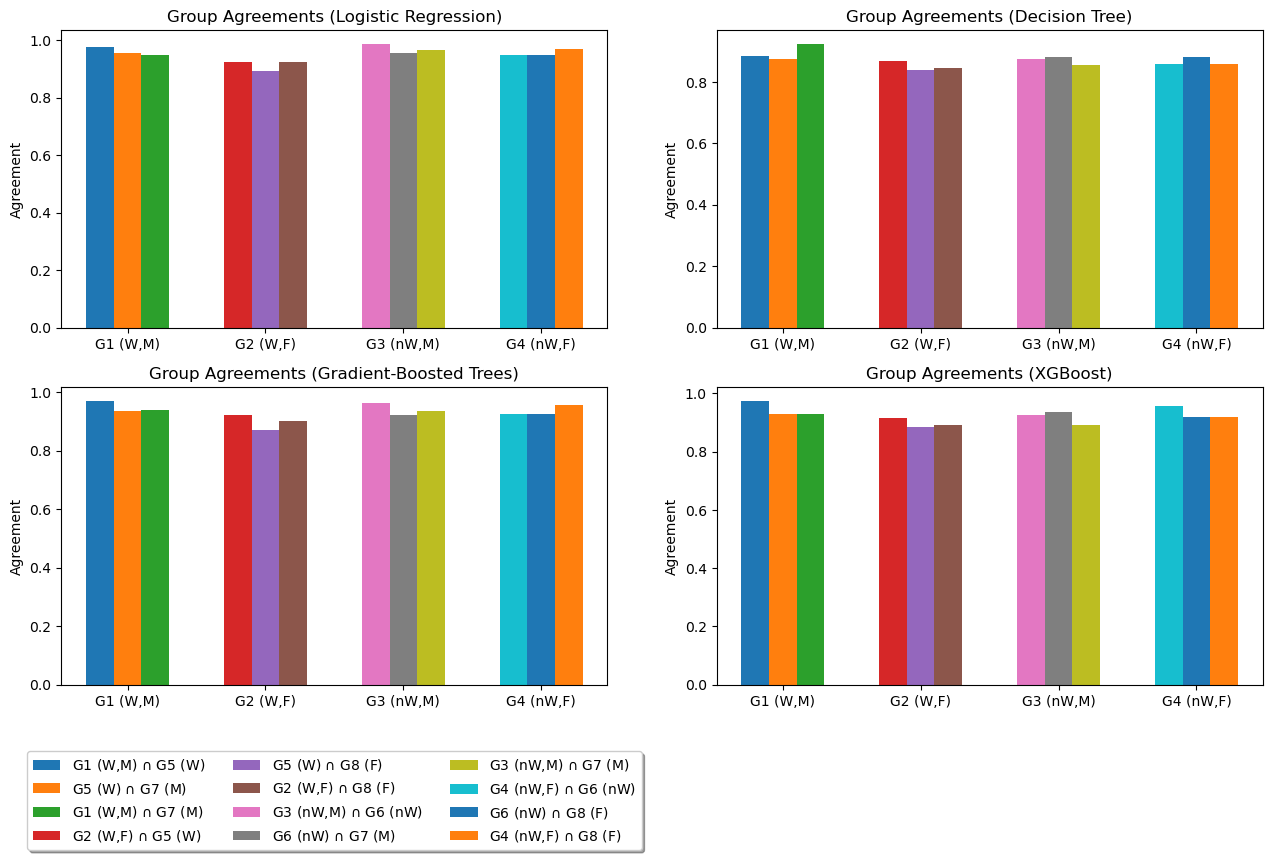

In [39]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

# LOGISTIC REGRESSION
rect11 = ax[0][0].bar(0 - bar_width, lr_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[0][0].bar(0, lr_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[0][0].bar(0 + bar_width, lr_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[0][0].bar(1 - bar_width, lr_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[0][0].bar(1, lr_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[0][0].bar(1 + bar_width, lr_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[0][0].bar(2 - bar_width, lr_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[0][0].bar(2, lr_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[0][0].bar(2 + bar_width, lr_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[0][0].bar(3 - bar_width, lr_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[0][0].bar(3, lr_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[0][0].bar(3 + bar_width, lr_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

# DECISION TREE
rect11 = ax[0][1].bar(0 - bar_width, dt_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[0][1].bar(0, dt_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[0][1].bar(0 + bar_width, dt_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[0][1].bar(1 - bar_width, dt_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[0][1].bar(1, dt_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[0][1].bar(1 + bar_width, dt_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[0][1].bar(2 - bar_width, dt_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[0][1].bar(2, dt_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[0][1].bar(2 + bar_width, dt_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[0][1].bar(3 - bar_width, dt_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[0][1].bar(3, dt_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[0][1].bar(3 + bar_width, dt_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[0][1].set_ylabel('Agreement')
ax[0][1].set_title('Group Agreements (Decision Tree)')
ax[0][1].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

# GRADIENT-BOOSTED TREES
rect11 = ax[1][0].bar(0 - bar_width, gb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[1][0].bar(0, gb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[1][0].bar(0 + bar_width, gb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[1][0].bar(1 - bar_width, gb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[1][0].bar(1, gb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[1][0].bar(1 + bar_width, gb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[1][0].bar(2 - bar_width, gb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[1][0].bar(2, gb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[1][0].bar(2 + bar_width, gb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[1][0].bar(3 - bar_width, gb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[1][0].bar(3, gb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[1][0].bar(3 + bar_width, gb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

# XGBOOST
rect11 = ax[1][1].bar(0 - bar_width, xgb_group_pairs_agreements[0], bar_width, 
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[0][0], group_names[group_pairs[0][0]],
                                                        group_pairs[0][1], group_names[group_pairs[0][1]]))
rect12 = ax[1][1].bar(0, xgb_group_pairs_agreements[1], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[1][0], group_names[group_pairs[1][0]],
                                                        group_pairs[1][1], group_names[group_pairs[1][1]]))
rect13 = ax[1][1].bar(0 + bar_width, xgb_group_pairs_agreements[2], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[2][0], group_names[group_pairs[2][0]],
                                                        group_pairs[2][1], group_names[group_pairs[2][1]]))

rect21 = ax[1][1].bar(1 - bar_width, xgb_group_pairs_agreements[3], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[3][0], group_names[group_pairs[3][0]],
                                                        group_pairs[3][1], group_names[group_pairs[3][1]]))
rect22 = ax[1][1].bar(1, xgb_group_pairs_agreements[4], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[4][0], group_names[group_pairs[4][0]],
                                                        group_pairs[4][1], group_names[group_pairs[4][1]]))
rect23 = ax[1][1].bar(1 + bar_width, xgb_group_pairs_agreements[5], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[5][0], group_names[group_pairs[5][0]],
                                                        group_pairs[5][1], group_names[group_pairs[5][1]]))

rect31 = ax[1][1].bar(2 - bar_width, xgb_group_pairs_agreements[6], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[6][0], group_names[group_pairs[6][0]],
                                                        group_pairs[6][1], group_names[group_pairs[6][1]]))
rect32 = ax[1][1].bar(2, xgb_group_pairs_agreements[7], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[7][0], group_names[group_pairs[7][0]],
                                                        group_pairs[7][1], group_names[group_pairs[7][1]]))
rect33 = ax[1][1].bar(2 + bar_width, xgb_group_pairs_agreements[8], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[8][0], group_names[group_pairs[8][0]],
                                                        group_pairs[8][1], group_names[group_pairs[8][1]]))

rect41 = ax[1][1].bar(3 - bar_width, xgb_group_pairs_agreements[9], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[9][0], group_names[group_pairs[9][0]],
                                                        group_pairs[9][1], group_names[group_pairs[9][1]]))
rect42 = ax[1][1].bar(3, xgb_group_pairs_agreements[10], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[10][0], group_names[group_pairs[10][0]],
                                                        group_pairs[10][1], group_names[group_pairs[10][1]]))
rect43 = ax[1][1].bar(3 + bar_width, xgb_group_pairs_agreements[11], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[11][0], group_names[group_pairs[11][0]],
                                                        group_pairs[11][1], group_names[group_pairs[11][1]]))

ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

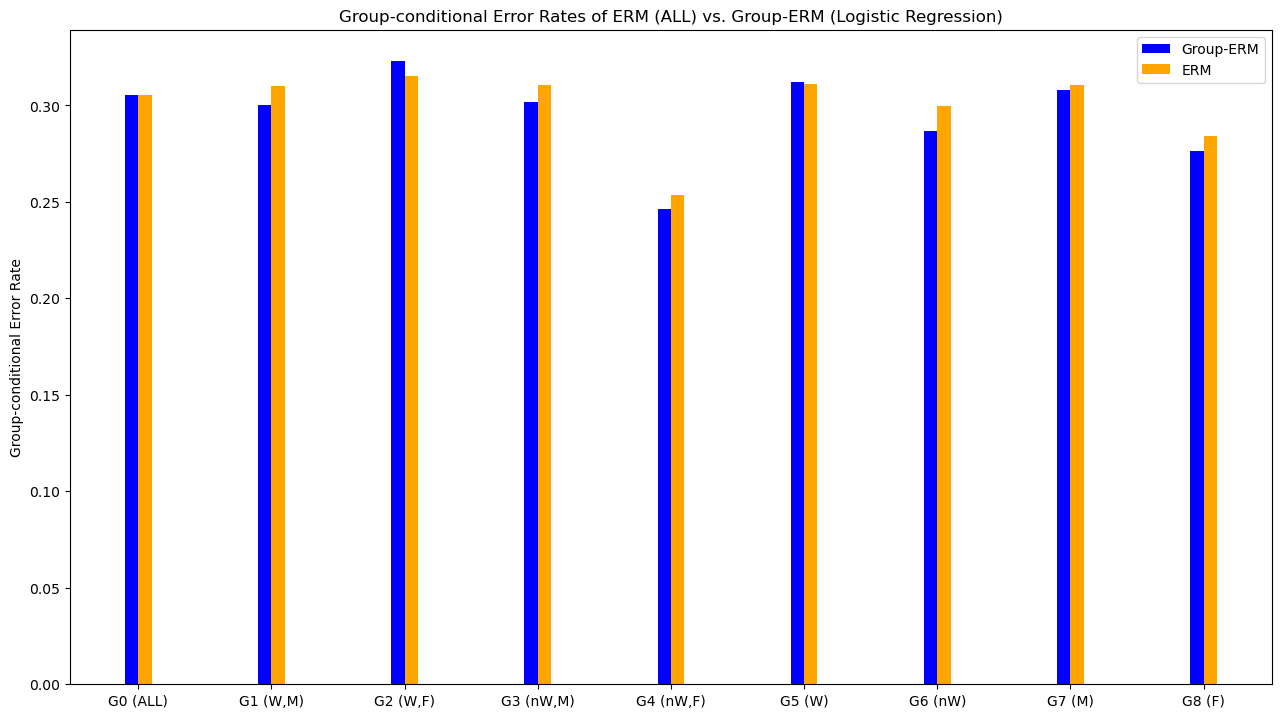

In [40]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, lr_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, lr_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, lr_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, lr_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (Logistic Regression)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

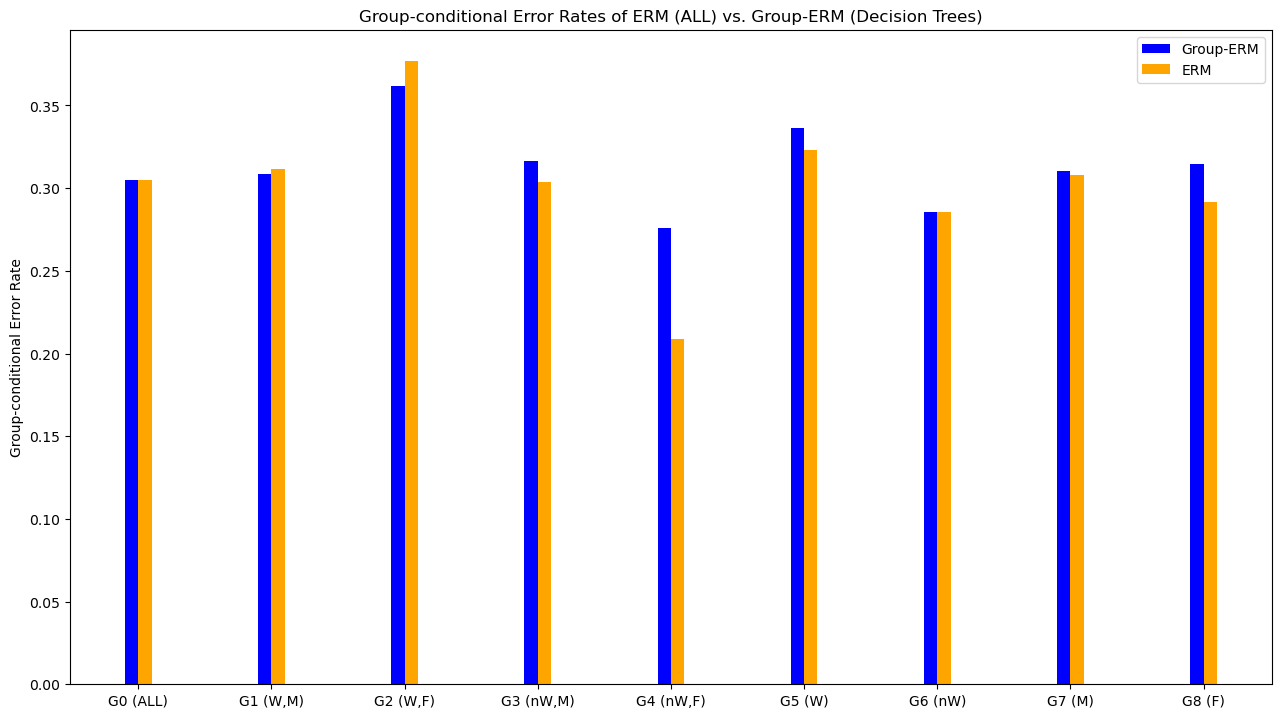

In [41]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, dt_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, dt_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, dt_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, dt_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (Decision Trees)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

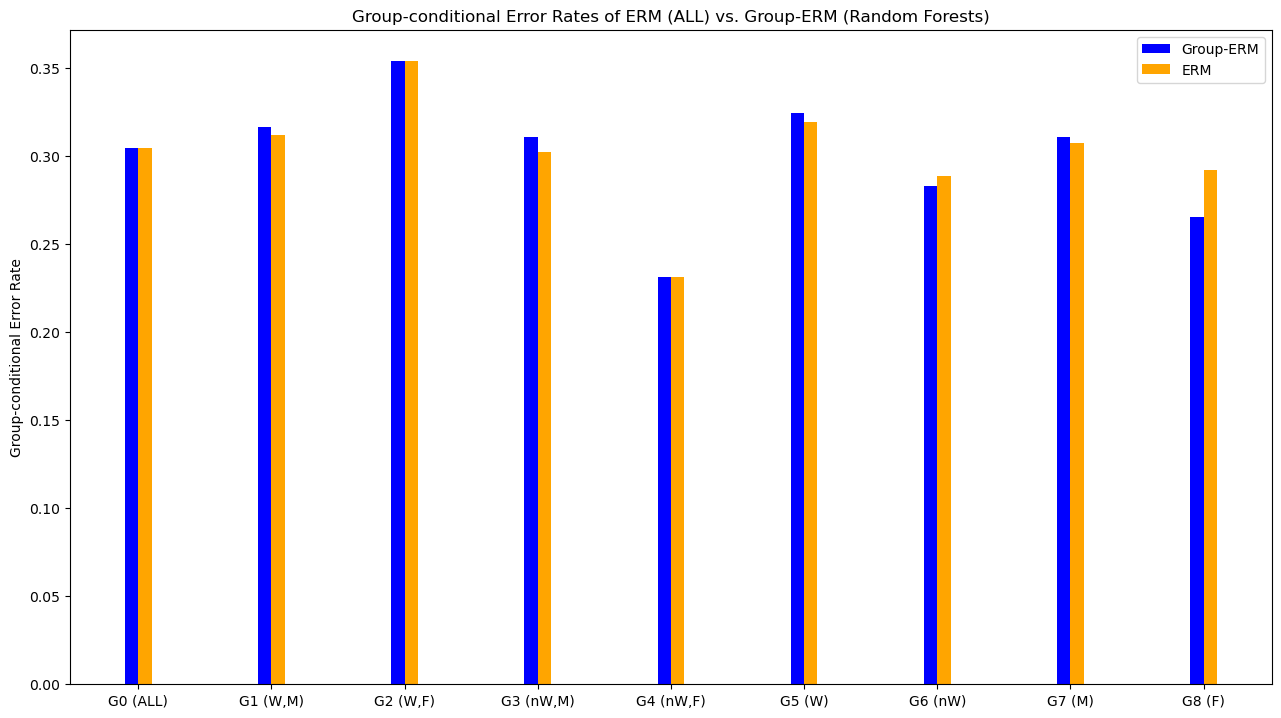

In [42]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, rf_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, rf_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (Random Forests)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

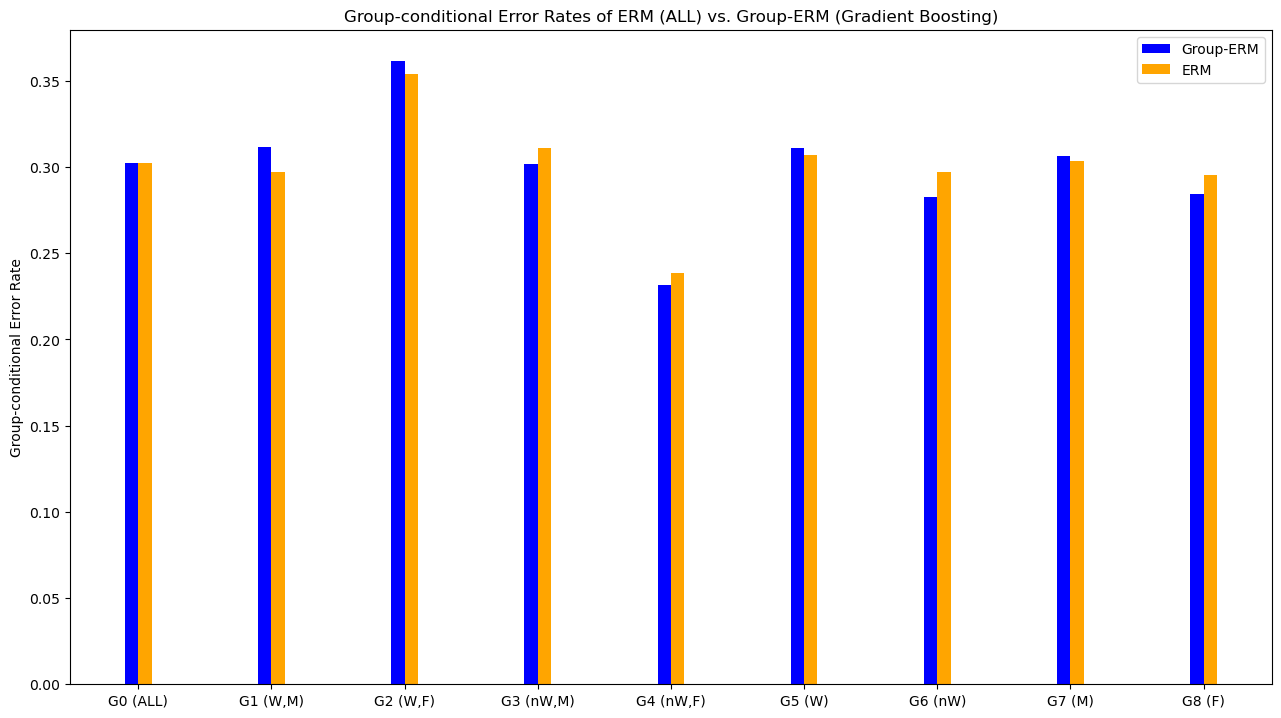

In [43]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, gb_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, gb_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (Gradient Boosting)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

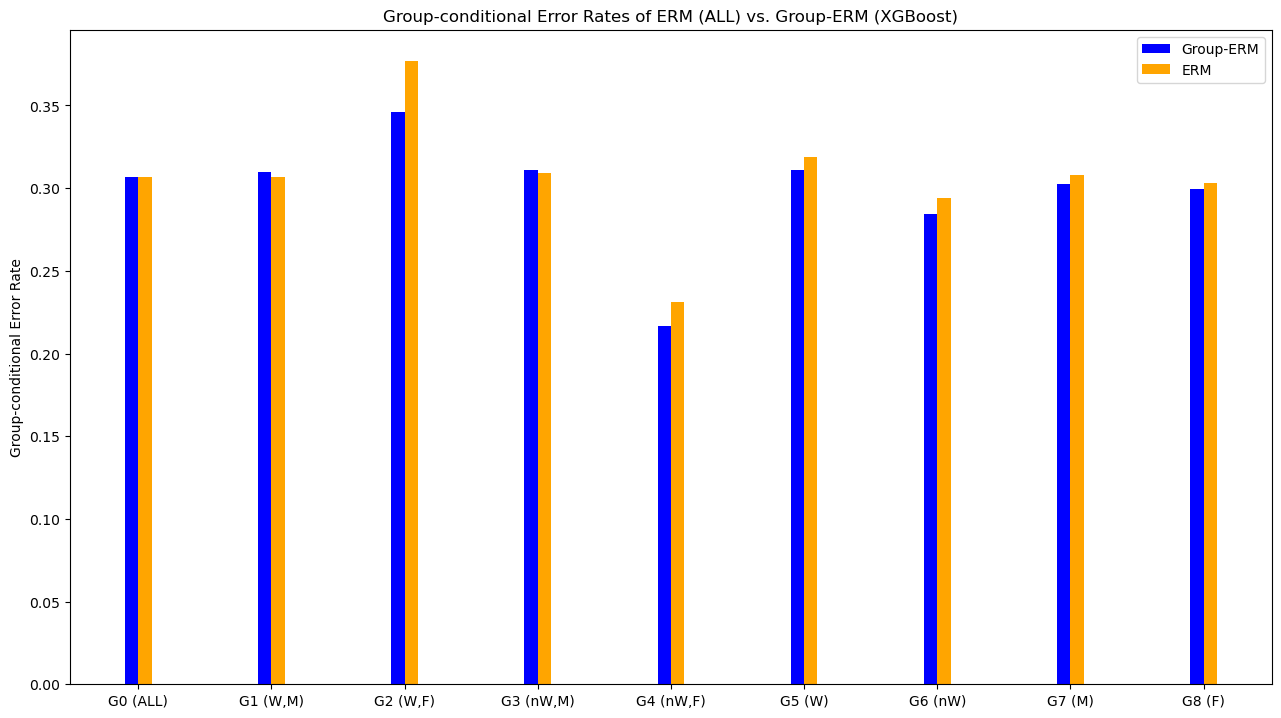

In [44]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, xgb_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, xgb_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, xgb_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, xgb_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (XGBoost)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

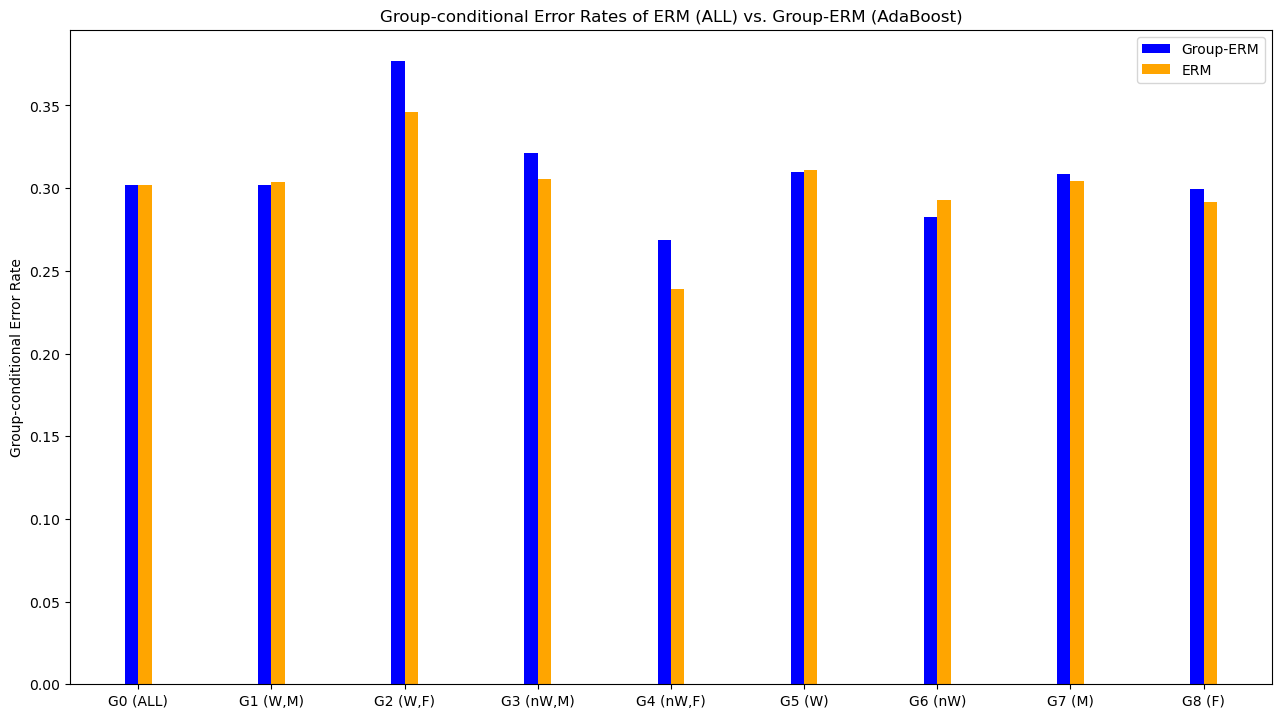

In [45]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 0.5 * bar_width, ada_test_err[g], bar_width, label="Group-ERM", color="blue")
        ax.bar(g + 0.5 * bar_width, ada_erm_test_err[g], bar_width, label="ERM", color="orange")
    else:
        ax.bar(g - 0.5 * bar_width, ada_test_err[g], bar_width, color="blue")
        ax.bar(g + 0.5 * bar_width, ada_erm_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM (AdaBoost)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()